In [1]:
import pandas as pd
from numpy import timedelta64
import os 
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
%matplotlib inline

In [7]:
def read_input_data(dataset):
    df = pd.read_excel(dataset) # read the data set
    df2 = df.iloc[:,1:].mul(4) # multiply data by 4 to account for kWhr
    df2.insert(0, 'Time', df['Time'].values)
    return df2

def generate_plot(full_day_ts, above_mean_ts, avg, date, building, start_date, end_date):
    '''generates and saves the plot with Matplotlib'''
    plot_name = f'{date}-{building}'
    peak = full_day_ts[building].max() # find the max
    peak_idx = full_day_ts[building].idxmax() # find the index where the highest peak occurs
    coned_sma = full_day_ts[building].rolling(2).mean()
    plt.plot(full_day_ts['Time'], full_day_ts[building], label='Load Profile') 
    plt.axvline(x=full_day_ts['Time'][peak_idx], ymax=peak, color='green', linestyle='--', label='Max. Peak') # vertical line for peak
    plt.axhline(y=avg, color='purple', linestyle='--', label='Avg. Baseline') # horizontal line for mean
    plt.xlim(start_date, end_date) # change the xlimit 
    plt.xticks(rotation=45) 
    plt.ylabel('kW') 
    plt.title(plot_name)
    plt.fill_between(full_day_ts['Time'], full_day_ts[building], avg, 
                     where=(full_day_ts[building]> avg), interpolate=True, color='r',alpha=0.2)
    plt.fill_between(full_day_ts['Time'], full_day_ts[building], avg, 
                     where=(full_day_ts[building]< avg), interpolate=True, color='g',alpha=0.2)
    plt.plot(full_day_ts['Time'], coned_sma, label='ConEdison SMA')
    plt.grid()
    plt.legend()
    fig = plt.gcf() 
    fig.set_size_inches(18.5, 10.5) 
    fig.savefig(os.path.join(".", "Plots", f"{plot_name}.png"), dpi=100) # save the figure
    
def battery_capacity(df, building):
    x = df.index
    y = df[building]
    avg = df[building].mean() 
    
    polygon_points = []
    current_point = []
    polystart = 0
    
    for x_val, y_val in zip(x, y):
        if y_val >= avg:
            if polystart == 0:
                polystart = x_val - 1
            current_point = [x_val-1, y[x_val-1]]
            polygon_points.append(current_point)
        if y_val < avg and len(polygon_points) > 0:
            polygon_points.append([x_val-1, y[x_val-1]])
            current_point = [x_val, y_val]
            polygon_points.append(current_point)
            break
            
    load_curve = polygon_points
    for point in load_curve[:0:-1]:
        polygon_points.append([point[0], avg])
    polygon_points.append(polygon_points[0])
    polygon = Polygon(polygon_points)
    area = polygon.area
    return area, polygon_points
     
# finds hours where the power consumption is above the mean 
def find_time_above_avg(df, date='2022-02-01', time_window=1,
                        building='CUNY City College of New York - 490118080600007 - Administration.E13 - 12785810'):
    '''finds the time (in hours) where the power consumption was above average calculated for the same time period'''
    start_date = pd.Timestamp(f'{date}') # start and end times
    end_date = pd.Timestamp(f'{date}') + timedelta64(time_window, 'D')
    daily_ts = df.loc[(df["Time"] > start_date) & (df["Time"] < end_date)] 
    peak = daily_ts[building].max()
    avg = daily_ts[building].mean() 
    above_mean_df = daily_ts[daily_ts[building] > avg]
    
    generate_plot(daily_ts, above_mean_df, avg, date, building, start_date, end_date)
    diff = peak - avg
    time_above_avg = ((above_mean_df.Time.max() - above_mean_df.Time.min())/ timedelta64(1, 'D')) * 24
    
    print(battery_capacity(daily_ts, building))
    
    return {"Duration (Hr)": time_above_avg, "Crest Factor (kW)": diff} 

In [3]:
data = read_input_data(os.path.join(".", "Data", "data2019-2020.xlsx"))

(25.136842105263327, [[3005, 1808.0], [3006, 1896.0], [3007, 1848.0], [3007, 1863.2421052631578], [3006, 1863.2421052631578], [3005, 1808.0]])


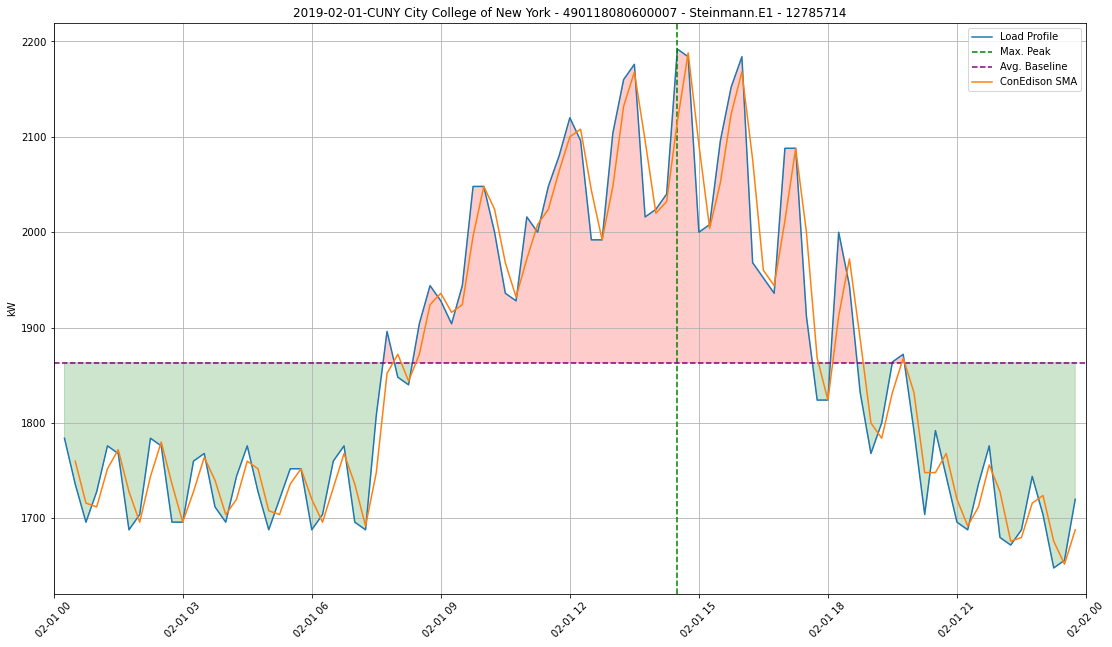

In [8]:
t = find_time_above_avg(data, date='2019-02-01', time_window=1,
                       building='CUNY City College of New York - 490118080600007 - Steinmann.E1 - 12785714')

In [ ]:
t = find_time_above_avg(data, date='2019-02-01', time_window=1,
                       building='CUNY City College of New York - 490118085800016 - NAC.NorthsideR-521.E17 - 7252811')
t

# Corrections
    - ✔ multiply data by 4 to account for kWhr
    
# Addtional attributes for graphs
     - ✔ average baseline to max. peak difference
     - ✔ ConEdison Avg load curve: 30 min moving window of averaged meter values
     - ✔ Labels on graph
     - ✔ add shading to profile above baseline
     
# Addtional 
     - Required Battery Capacity: integration below curve w.r.t average baseline
     - Duration of load profile above the average including the time stamp (half done)
     - * Separate graph that shows the averaged monthly load profile with all preceeding attributes
     - 